## 폐렴 진단기 🩺🩸👩🏻‍⚕️

___
💬 의료 영상에서의 CV에 관한 프로젝트입니다. Data augmentation과 imbalance 처리, 하이퍼파라미터 튜닝 등을 다룹니다.

___

### 1. Set-up

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

필요한 변수들 생성

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


### 📌 하이퍼 파라미터 (추후에 조정)

In [4]:
BATCH_SIZE = 16
EPOCHS = 25

### 2. 데이터 가져오기

In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


`validation data`의 값이 너무 적으므로 `train data`의 일부를 `validation data`에 할당한다. (`train`:`val` = 8:2 가 되도록)

* `tf.io.gfile.glob()` : 주어진 패턴과 일치하는 파일 목록을 반환
* `math.floor()` : 소수점 이하를 버림  
* `random.shuffle()` : 리스트 항목을 섞기

In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


`train data` = 4185개  
`validation data` = 1047개  
`test data` = 624

정상 이미지와 폐렴 환자 이미지의 개수 확인

파일 경로에 NORMAL / PNEUMONIA 이 있는지를 기준으로 구분

In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


`training data`의 클래스 별 데이터 수가 편중되어 있음을 알 수 있다. (imbalance) 이 경우 training이 잘되지 않을 수 있으므로 차후에 조정해준다. 

> training data에서는 클래스 별 balance가 좋을수록 training이 잘 됨. test와 validation에서는 관련 없음.

tf.data 인스턴스를 만들어 mini-batch로 작업할 수 있도록 해준다.

* batch size: gradient descent 할 때 몇 개의 데이터를 가지고 하는 지
* mini-batch: batch size가 1인 SGD와 batch size가 전체 데이터 수인 full batch의 단점을 보완한 것. 일정 정도로 batch를 설정하여 최적화를 진행한다. SGD에 비해서는 정확성을 높이고, full batch에 비해서는 시간을 단축할 수 있다.

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


폐렴이면 양성(True), 노말이면 음성(False)인 라벨 데이터를 만들어 준다.

In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지의 사이즈를 통일시키고 용량을 줄이기 위해 이미지 사이즈를 전체적으로 줄여준다.

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋 만들기

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


test 데이터 셋 만들기

In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


`prepare_for_training` 함수 정의

tf.data 파이프 라인

* shuffle(): 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소 선택

* repeat(): 에포크를 진행하면서 여러 번 데이터셋을 사용할 수 있게 해줌

* batch(): 정해진 batch size 로 배치를 나눠줌

* prefetch(): 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비. 쉬는 리소스가 없도록 해 줌.

In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

___

### 3. 데이터 시각화

train에 있는 첫 번 째 batch를 추출. 추출된 배치를 image와 label 데이터 셋으로 나눔.

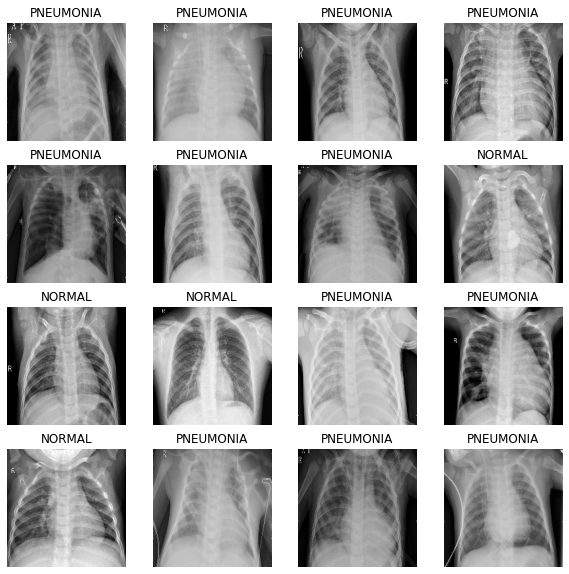

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

___

### 4. CNN 모델링

### `convolution block`

1. Convolution
2. Convolution
3. Batch Normalizatoin(Gradient 소실, Gradient 폭발을 방지)
4. Max Pooling

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### `dense block`

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

보통은 `batch normalization`과 `drop out`을 동시에 사용하지 않지만 예외적으로 성능 향상에 도움이 되는 경우가 있음. (뒤에서 비교)

[Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)

[Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

___

### 5. 데이터 imbalance 처리

### `Weight balancing`
training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법. 

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정.

=> 데이터 건수가 많을수록 더 작은 loss값을 갖도록. 반대로 데이터 건수가 적을수록 더 큰 loss 값을 갖도록 한다.

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


___

### 6. 모델 훈련

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 62s 189ms/step - loss: 0.3805 - accuracy: 0.8087 - precision: 0.9568 - recall: 0.7779 - val_loss: 0.6995 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2281 - accuracy: 0.9066 - precision: 0.9725 - recall: 0.8999 - val_loss: 1.1147 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1856 - accuracy: 0.9325 - precision: 0.9799 - recall: 0.9282 - val_loss: 1.1415 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2020 - accuracy: 0.9279 - precision: 0.9753 - recall: 0.9266 - val_loss: 0.0788 - val_accuracy: 0.9683 - val_precision: 0.9692 - val_recall: 0.9882
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1576 - accura

___

### 7. 결과 확인

그래프로 에포크마다 모델의 precision, recall, accuracy, loss의 변화를 확인

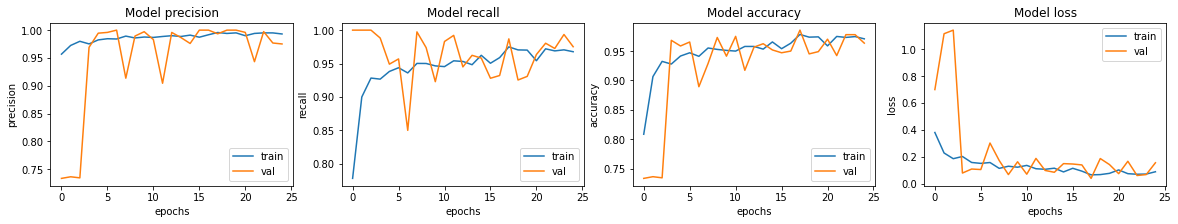

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델 평가

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 0.9202 - accuracy: 0.7788 - precision: 0.7423 - recall: 0.9897
Loss: 0.920192539691925,
Accuracy: 0.7788461446762085,
Precision: 0.7423076629638672,
Recall: 0.9897435903549194


### Accuracy: 0.77 | Recall: 0.99

____

## 💡 성능 개선하기

### 1) Set-up

하이퍼 파라미터 조정

위에서 보면 모델의 정확도가 변동성이 크므로 batch_size는 키우는 것이 좋아보인다. batch_size를 조절한 후 에포크 값을 조절하여 적절한 하이퍼 파라미터를 찾아볼 것이다.

### 🔎 BATCH_SIZE: 16 -> 32 | EPOCHS: 그대로 25

In [25]:
BATCH_SIZE = 32
EPOCHS = 25

In [26]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 37s 219ms/step - loss: 0.4625 - accuracy: 0.7654 - precision: 0.9442 - recall: 0.7291 - val_loss: 0.5886 - val_accuracy: 0.7246 - val_precision: 0.7246 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 28s 213ms/step - loss: 0.3055 - accuracy: 0.8697 - precision: 0.9674 - recall: 0.8520 - val_loss: 0.6924 - val_accuracy: 0.7227 - val_precision: 0.7227 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 28s 216ms/step - loss: 0.2513 - accuracy: 0.9072 - precision: 0.9722 - recall: 0.9013 - val_loss: 0.8398 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 28s 219ms/step - loss: 0.2069 - accuracy: 0.9260 - precision: 0.9755 - recall: 0.9238 - val_loss: 1.1156 - val_accuracy: 0.7285 - val_precision: 0.7285 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 29s 225ms/step - loss: 0.1830 - accura

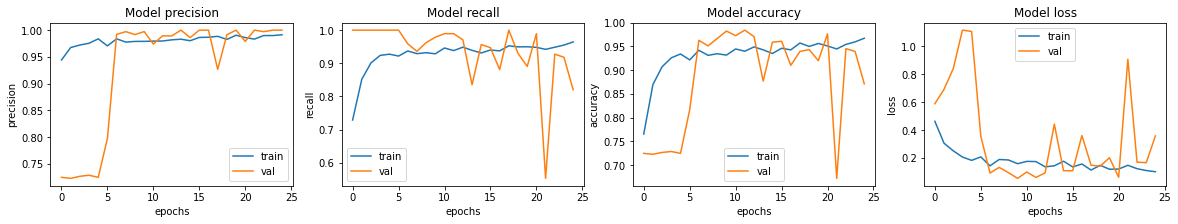

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.3393 - accuracy: 0.8830 - precision: 0.9249 - recall: 0.8846
Loss: 0.3392506241798401,
Accuracy: 0.8830128312110901,
Precision: 0.9249329566955566,
Recall: 0.8846153616905212


### ✅ Accuracy: 0.77 → 0.88 로 증가 | Recall: 0.99 →  0.88 로 감소

___
과적합된 것 같아 에포크수를 줄여 본다.

### 🔎 BATCH_SIZE: 32 | EPOCHS: 25 → 20

In [29]:
BATCH_SIZE = 32
EPOCHS = 20

In [30]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 37s 220ms/step - loss: 0.5505 - accuracy: 0.7063 - precision: 0.9051 - recall: 0.6793 - val_loss: 0.5995 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 28s 214ms/step - loss: 0.3261 - accuracy: 0.8543 - precision: 0.9564 - recall: 0.8414 - val_loss: 0.6124 - val_accuracy: 0.7402 - val_precision: 0.7402 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 28s 213ms/step - loss: 0.2781 - accuracy: 0.8865 - precision: 0.9666 - recall: 0.8780 - val_loss: 0.9480 - val_accuracy: 0.7246 - val_precision: 0.7246 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 28s 218ms/step - loss: 0.2238 - accuracy: 0.9212 - precision: 0.9700 - recall: 0.9221 - val_loss: 1.8394 - val_accuracy: 0.7051 - val_precision: 0.7051 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 29s 222ms/step - loss: 0.2099 - accura

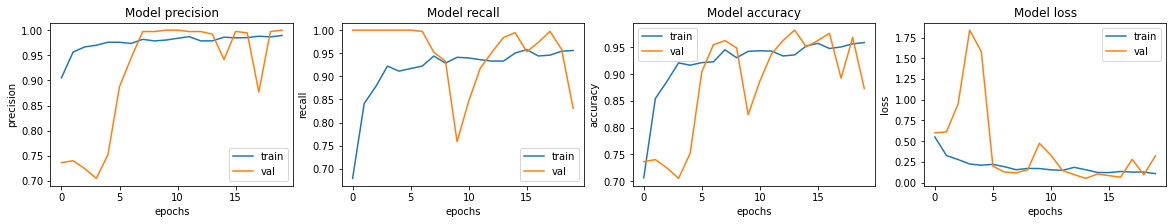

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.3171 - accuracy: 0.8958 - precision: 0.9032 - recall: 0.9333
Loss: 0.3170546591281891,
Accuracy: 0.8958333134651184,
Precision: 0.9032257795333862,
Recall: 0.9333333373069763


### ✅ Accuracy: 0.77 → 0.89 로 증가 | Recall: 0.99 → 0.93로 감소

____

### 2) Data augmentation

### 🔎 augment 좌우 반전 적용

In [22]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

___

### 3) 데이터 시각화

### ❗❗❗ 왜인지 여기서 계속 Dead Kernel 오류가 뜬다...

In [31]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

KeyboardInterrupt: 

모델 훈련

In [23]:
BATCH_SIZE = 32
EPOCHS = 20

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 42s 223ms/step - loss: 0.5261 - accuracy: 0.7115 - precision: 0.9291 - recall: 0.6619 - val_loss: 0.6156 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 28s 219ms/step - loss: 0.2749 - accuracy: 0.8750 - precision: 0.9721 - recall: 0.8566 - val_loss: 0.6387 - val_accuracy: 0.7285 - val_precision: 0.7285 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 29s 220ms/step - loss: 0.2472 - accuracy: 0.9096 - precision: 0.9749 - recall: 0.9018 - val_loss: 0.7518 - val_accuracy: 0.7578 - val_precision: 0.7578 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 29s 228ms/step - loss: 0.2253 - accuracy: 0.9135 - precision: 0.9770 - recall: 0.9052 - val_loss: 1.0336 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 31s 236ms/step - loss: 0.1857 - accura

모델 평가

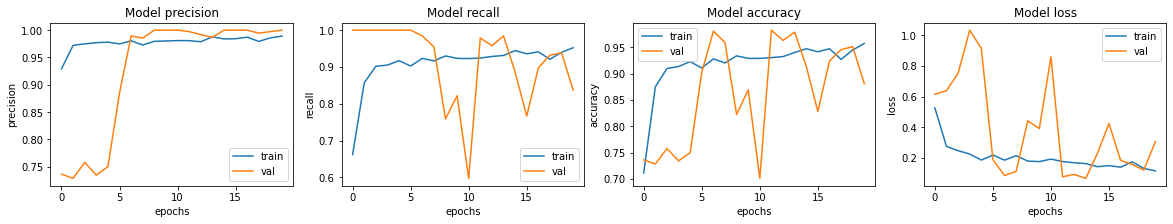

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.3543 - accuracy: 0.8734 - precision: 0.8977 - recall: 0.9000
Loss: 0.35426658391952515,
Accuracy: 0.8733974099159241,
Precision: 0.8976982235908508,
Recall: 0.8999999761581421


### ✅ Accuracy: 0.87 | Recall: 0.90

### 🔎 augment 밝기 조정 적용

In [26]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    image = tf.image.random_brightness(image, 0.5) # 밝기 조정
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [27]:
BATCH_SIZE = 32
EPOCHS = 20

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 57s 363ms/step - loss: 0.6108 - accuracy: 0.6762 - precision: 0.8948 - recall: 0.6402 - val_loss: 0.6298 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 47s 364ms/step - loss: 0.3076 - accuracy: 0.8683 - precision: 0.9666 - recall: 0.8521 - val_loss: 0.6507 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 48s 368ms/step - loss: 0.2318 - accuracy: 0.9075 - precision: 0.9744 - recall: 0.8992 - val_loss: 0.9378 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 49s 375ms/step - loss: 0.2038 - accuracy: 0.9240 - precision: 0.9761 - recall: 0.9207 - val_loss: 1.2205 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 51s 393ms/step - loss: 0.1857 - accura

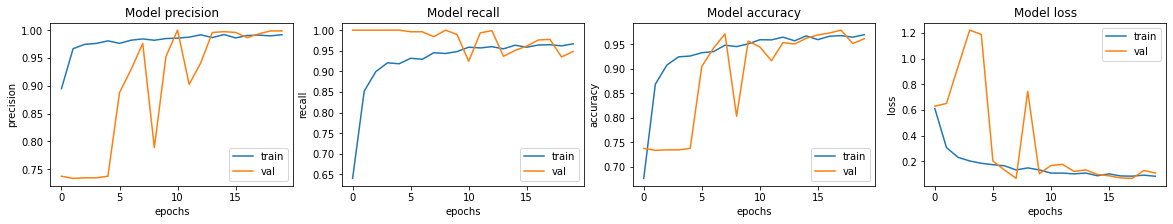

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.6649 - accuracy: 0.8301 - precision: 0.7971 - recall: 0.9769
Loss: 0.664861261844635,
Accuracy: 0.8301281929016113,
Precision: 0.7970711588859558,
Recall: 0.9769230484962463


### ✅ Accuracy: 0.83 | Recall: 0.98

___

### 4) CNN 모델 조정

### 🔎 Batch Normalization O | Dropout X

In [30]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [31]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

모델 학습

In [32]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 56s 366ms/step - loss: 0.3848 - accuracy: 0.8007 - precision: 0.9478 - recall: 0.7748 - val_loss: 0.5833 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 46s 358ms/step - loss: 0.1967 - accuracy: 0.9204 - precision: 0.9785 - recall: 0.9129 - val_loss: 0.7860 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 46s 359ms/step - loss: 0.1778 - accuracy: 0.9353 - precision: 0.9771 - recall: 0.9351 - val_loss: 1.0943 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 47s 364ms/step - loss: 0.1438 - accuracy: 0.9442 - precision: 0.9792 - recall: 0.9451 - val_loss: 1.3509 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 48s 373ms/step - loss: 0.1300 - accura

모델 평가

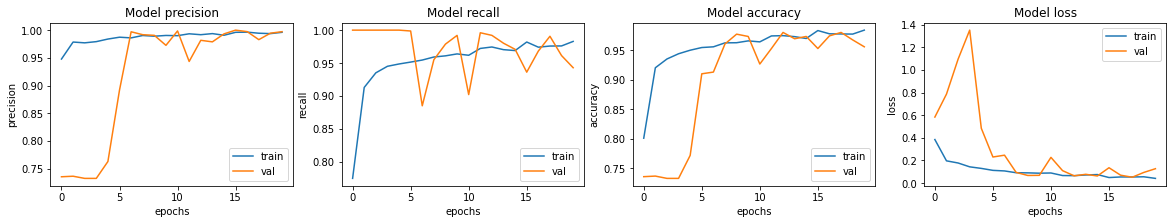

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 0.7003 - accuracy: 0.8125 - precision: 0.7850 - recall: 0.9641
Loss: 0.7003313302993774,
Accuracy: 0.8125,
Precision: 0.7849686741828918,
Recall: 0.964102566242218


### ✅ Accuracy:  0.81 | Recall: 0.96

### 🔎 Batch Normalization X | Dropout O

In [41]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [42]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

모델 학습

In [43]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 57s 367ms/step - loss: 0.5139 - accuracy: 0.7260 - precision: 0.8736 - recall: 0.7387 - val_loss: 0.5842 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 47s 365ms/step - loss: 0.2491 - accuracy: 0.8841 - precision: 0.9777 - recall: 0.8639 - val_loss: 0.8536 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 47s 367ms/step - loss: 0.2474 - accuracy: 0.9000 - precision: 0.9695 - recall: 0.8938 - val_loss: 0.7831 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 48s 373ms/step - loss: 0.1915 - accuracy: 0.9248 - precision: 0.9786 - recall: 0.9188 - val_loss: 2.1869 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 50s 388ms/step - loss: 0.1536 - accura

모델 평가

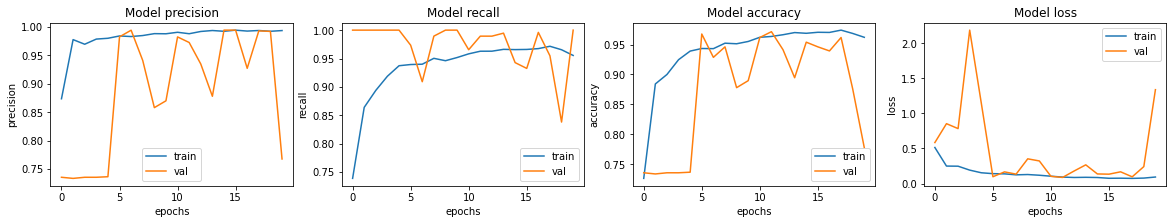

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 6.3285 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 6.328543663024902,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### ✅ Accuracy: 0.62 | Recall: 1.0

___

### 5) 데이터 imbalance 처리

### 🔎 `class_weight` 처리 생략

In [46]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [47]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 57s 367ms/step - loss: 0.6647 - accuracy: 0.6627 - precision: 0.8374 - recall: 0.6786 - val_loss: 0.5909 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 48s 369ms/step - loss: 0.3028 - accuracy: 0.8774 - precision: 0.9338 - recall: 0.8987 - val_loss: 0.9391 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 47s 366ms/step - loss: 0.1859 - accuracy: 0.9300 - precision: 0.9560 - recall: 0.9495 - val_loss: 1.0836 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 48s 374ms/step - loss: 0.1513 - accuracy: 0.9452 - precision: 0.9644 - recall: 0.9619 - val_loss: 1.4983 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 50s 384ms/step - loss: 0.1490 - accura

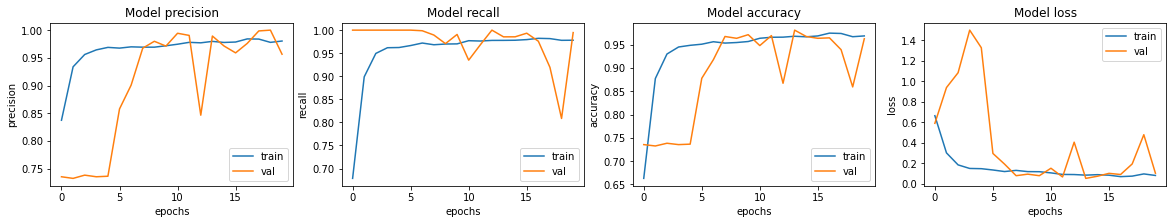

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [49]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 1.4193 - accuracy: 0.7083 - precision: 0.6818 - recall: 1.0000
Loss: 1.4192888736724854,
Accuracy: 0.7083333134651184,
Precision: 0.6818181872367859,
Recall: 1.0


### ✅ Accuracy: 0.71 | Recall: 1.0

___

### 6) 모델 훈련 조정

### 🔎 `learning rate` 조정 (lr=0.001)

In [55]:
from tensorflow import keras
from keras import optimizers
Adam = keras.optimizers.Adam(lr=0.001)


with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=Adam,
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 55s 354ms/step - loss: 0.8576 - accuracy: 0.5012 - precision: 0.7442 - recall: 0.5008 - val_loss: 0.8450 - val_accuracy: 0.2607 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
130/130 [==============================] - 46s 359ms/step - loss: 0.6208 - accuracy: 0.6353 - precision: 0.8727 - recall: 0.5975 - val_loss: 0.6101 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 46s 358ms/step - loss: 0.2938 - accuracy: 0.8659 - precision: 0.9739 - recall: 0.8426 - val_loss: 0.8293 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 48s 367ms/step - loss: 0.2091 - accuracy: 0.9204 - precision: 0.9782 - recall: 0.9134 - val_loss: 1.0080 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 48s 371ms/step - loss: 0.1810 

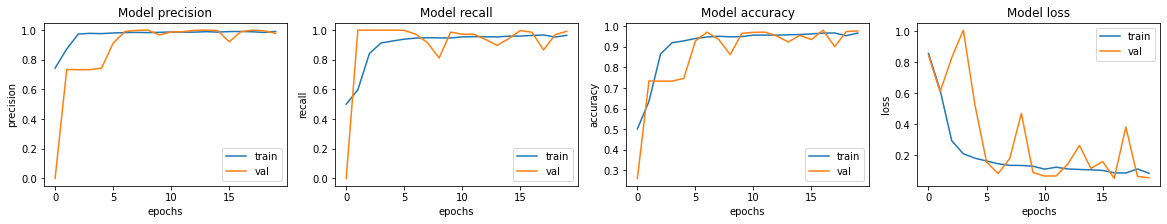

In [56]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [57]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 1.0547 - accuracy: 0.7452 - precision: 0.7119 - recall: 0.9949
Loss: 1.0546892881393433,
Accuracy: 0.745192289352417,
Precision: 0.7119265794754028,
Recall: 0.9948717951774597


### ✅ Accuracy: 0.75 | Recall: 0.99

### 🔎 optimizer 함수 변경 (rmsprop)

Epoch 1/20
130/130 [==============================] - 57s 364ms/step - loss: 0.3668 - accuracy: 0.8300 - precision: 0.9571 - recall: 0.8076 - val_loss: 0.6594 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 47s 361ms/step - loss: 0.2281 - accuracy: 0.9197 - precision: 0.9691 - recall: 0.9215 - val_loss: 0.9536 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 47s 367ms/step - loss: 0.1640 - accuracy: 0.9459 - precision: 0.9800 - recall: 0.9467 - val_loss: 1.1434 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 48s 370ms/step - loss: 0.1570 - accuracy: 0.9502 - precision: 0.9791 - recall: 0.9535 - val_loss: 1.5499 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 50s 385ms/step - loss: 0.1450 - accura

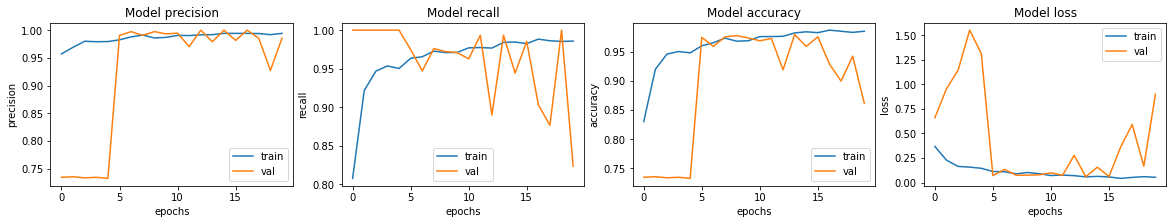

In [59]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

BATCH_SIZE = 32
EPOCHS = 20

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

### ✅ Accuracy: 0.74 | Recall: 90

____

## 🤔 회고

1. **하이퍼 파라미터 조정**: 하이퍼 파라미터를 적절히 조정하기만 해도 accuracy를 상당히 향상시킬 수 있었습니다. Batch_size를 크게 하는 것이 특히 유의미한 성능향상을 보여줍니다.

2. **Data augmentation**: **좌우 반전**을 이용한 data augmentation은 성능향상에 크게 도움이 되지는 않았습니다. 여러가지 데이터 증강 방법을 찾아보았습니다. cropping은 X-ray 사진이라는 데이터의 특성상 적합하지 않을 것 같고, 색상 반전이나 색상 조정 또한 같은 이유에서 성능을 저하시킬 것으로 판단하였습니다. 그래서 밝기를 조절하는 방식의 데이터 증강 방법을 적용하였습니다. **밝기 조절**을 이용한 data augmentation은 좌우 반전과 마찬가지로 성능향상에 큰 영향을 주지 못하였습니다. 대신 Recall값은 어느정도 향상되는 양상을 보였습니다.

3. **Regularizaton**: **Batch Normalization**만 사용한 경우 Dropout이 되지 않아 학습 시간이 길어질 줄 알았는데, 그렇지는 않았습니다. 성능은 저하되었습니다. **Dropout**만 사용한 경우 마찬가지로 성능은 저하되었습니다. **둘 다 모두 사용했을 경우** 가장 성능이 좋았습니다. 이번에 쓰인 데이터셋이 BN과 Dropout을 동시에 사용하는 것이 유리한 예외적인 케이스인 것 같습니다.

4. **Data Imbalance 처리**: PNEUMONIA 클래스의 데이터가 적어서 손실함수에 가중치를 주는 처리입니다. 이 처리를 하지 않았을 때보다 했을 때 확실히 더 성능이 좋았습니다.

5. **모델 학습 조정**: `learning rate`를 0.001로 설정하였으나 오히려 성능이 많이 떨어졌습니다. optimizer를 adam이 아닌 **rmsprop**으로 변경하였더니 약간의 성능개선이 있었습니다. 

**📌📌 결과적으로...** 하이퍼 파라미터 조정 외에는 다른 방법으로 그다지 큰 성능향상을 보일 수 없었습니다. **아무것도 안하고 BATCH_SIZE를 늘리고 EPOCHS를 줄이는 것이 가장 성능이 좋았습니다.** 어찌보면 다른 방법들을 먼저 적용한 다음에 맨 마지막에 하이퍼 파라미터를 조절하는 순서가 나았을 수도 있겠습니다. 다음 프로젝트에는 반대 순서로 시도해봐야겠습니다.